# Matrix multiplication from foundations

## Init

In [1]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

## Data

In [2]:
# Download the MNIST dataset
import gzip
import pickle
from urllib.request import urlretrieve

MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"

data_path = Path("data/mnist")
data_path.mkdir(exist_ok=True)
gz_path = data_path / "mnist.pkl.gz"

if not gz_path.exists():
    urlretrieve(MNIST_URL, gz_path)

# File contains a tuple of tuples for the x and y, train and validation data
# Images are 28x28
with gzip.open(gz_path, "rb") as file:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding="latin-1")

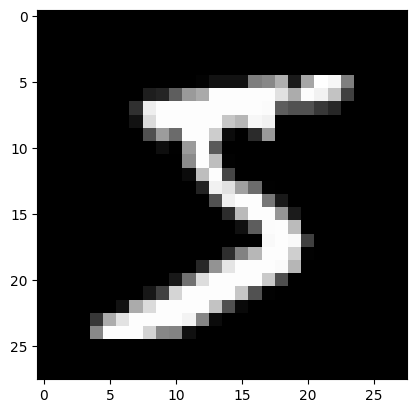

In [3]:
# Generator to chunk some iterable into fixed sizes
def chunks(to_chunk, chunk_size):
    for i in range(0, len(to_chunk), chunk_size):
        yield to_chunk[i : i + chunk_size]


mpl.rcParams["image.cmap"] = "gray"
img = list(chunks(x_train[0], 28))
plt.imshow(img)

# Could also do it like this
# from itertools import islice

# it = iter(x_train[0])
# img = list(iter(lambda: list(islice(it, 28)), []))
# mpl.rcParams["image.cmap"] = "gray"
# plt.imshow(img)

## Matrix and tensor

In [4]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs

    # Allows you to do m[a, b] rather than m[a][b]
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]


m = Matrix(img)
m[20, 15]

0.98828125

In [5]:
# Now we are allowed to use this feature of pytorch
import torch
from torch import tensor

tens = tensor(img)
tens[20, 15]

/tmp/ipykernel_17942/1989167947.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tens = tensor(img)


tensor(0.9883)

In [6]:
# Lets turn all of our data into tensors
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape, x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

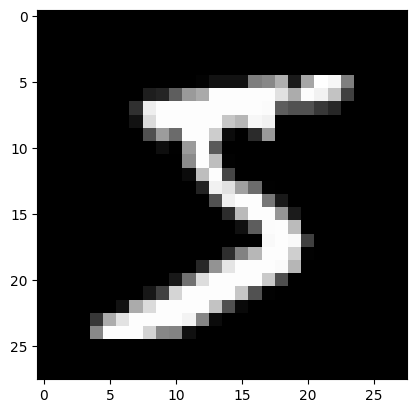

In [7]:
# We want to turn our 50000x784 tensor into 50000 28x28 tensors
# this is instead of our chunks
imgs = x_train.reshape(-1, 28, 28)

plt.imshow(imgs[0])

In [8]:
# The Y data contains just the expected digits for each image
y_train.shape, min(y_train), max(y_train)

(torch.Size([50000]), tensor(0), tensor(9))

## Random numbers

In [9]:
# Python used PRNG based on Witchman Hill algorithm

rnd_state = None


def seed(a):
    global rnd_state

    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)

    rnd_state = int(x) + 1, int(y) + 1, int(z + 1)


def rand():
    global rnd_state

    x, y, z = rnd_state

    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323

    rnd_state = x, y, z

    return (x / 30269 + y / 30307 + z / 30323) % 1.0


seed(151654216)
rnd_state

(11537, 5011, 1)

In [10]:
rand(), rand(), rand()

(0.6208010261127557, 0.5900796887572028, 0.4087658262430267)

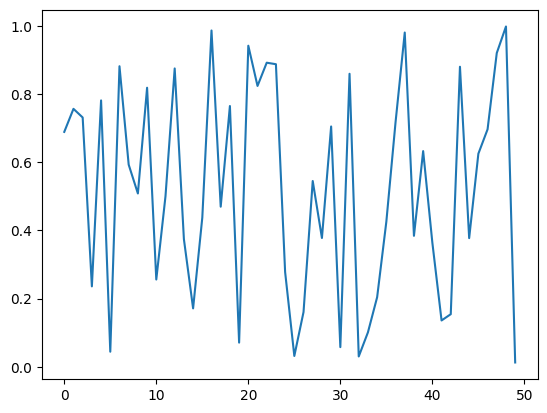

In [11]:
# No obvious relationship
plt.plot([rand() for _ in range(50)])

(array([ 965.,  984., 1048.,  951., 1031., 1026.,  998., 1051., 1014.,
         932.]),
 array([1.21291317e-04, 1.00083909e-01, 2.00046527e-01, 3.00009145e-01,
        3.99971762e-01, 4.99934380e-01, 5.99896998e-01, 6.99859616e-01,
        7.99822233e-01, 8.99784851e-01, 9.99747469e-01]),
 <BarContainer object of 10 artists>)

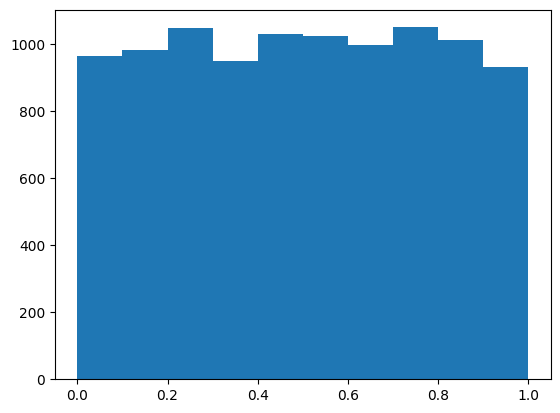

In [12]:
# Reasonably even distribution
plt.hist([rand() for _ in range(10000)])

Remember that this implementation needs reseeding on forks and is slow.

## Matrix multiplication

In [13]:
# Lets say we have our weights + bias
# 784 = 28*28, 10 = set of weights for each categorty (0 to 9)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

# And we will want to do 5 images at a time
m1 = x_valid[:5]
m2 = weights

# We want to multiply the two matrices together, what is their shape?
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [14]:
# row 1 of m1 col 1 of m2 and multiply each elementwise pair in turn and sum them. repeat for each row/col
# So how big is the resulting matrix, it will be 5 rows and 10 cols

m1Rows, m1Cols = m1.shape
m2Rows, m2Cols = m2.shape

result = torch.zeros(m1Rows, m2Cols)
result.shape

torch.Size([5, 10])

In [15]:
# Now we can do the multiplication
for i in range(m1Rows):  # 5
    for j in range(m2Cols):  # 10
        for k in range(m1Cols):  # 784
            result[i, j] = m1[i, k] * m2[k, j]

result

tensor([[-0., 0., 0., -0., 0., 0., -0., 0., 0., 0.],
        [-0., 0., 0., -0., 0., 0., -0., 0., 0., 0.],
        [-0., 0., 0., -0., 0., 0., -0., 0., 0., 0.],
        [-0., 0., 0., -0., 0., 0., -0., 0., 0., 0.],
        [-0., 0., 0., -0., 0., 0., -0., 0., 0., 0.]])

In [21]:
# In a function
def matmul(m1, m2):
    m1Rows, m1Cols = m1.shape
    m2Rows, m2Cols = m2.shape

    result = torch.zeros(m1Rows, m2Cols)

    for i in range(m1Rows):
        for j in range(m2Cols):
            for k in range(m1Cols):
                result[i, j] = m1[i, k] * m2[k, j]

    return result

In [23]:
# Its a bit slow
%timeit -n 5 matmul(m1,m2)

415 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


### Numba

Numba is a lib that takes python and turns it into machine code, it helps speed things up a lot.

For example if we were to speed up just the inner most loop.

In [52]:
from numba import njit


@njit
def dotproduct(m1, m2):
    result = 0.0
    for i in range(len(m1)):
        result += m1[i] * m2[i]

    return result


def matmul(m1, m2):
    m1Rows, m1Cols = m1.shape
    m2Rows, m2Cols = m2.shape

    result = torch.zeros(m1Rows, m2Cols)

    for i in range(m1Rows):
        for j in range(m2Cols):
            result[i, j] = dotproduct(m1[i, :], m2[:, j])

    return result

In [53]:
# The first run is slower as it does the compilation but the remaining runs end up faster
m1np = m1.numpy()
m2np = m2.numpy()
%timeit -n 20 matmul(m1np,m2np)

The slowest run took 12.30 times longer than the fastest. This could mean that an intermediate result is being cached.
821 µs ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


### Elementwise ops

In [54]:
a = tensor([10, 6, -4])
b = tensor([2, 8, 7])

# Go through each element and apply it to the each pair
a + b

tensor([12, 14,  3])

In [55]:
# This can be more complicated
# Here we do a < b to get [False, True, True]
# Then we do .float() to get [0, 1, 1]
# then we do .mean()
(a < b).float().mean()

tensor(0.6667)

In [56]:
# simple for rank 1 tensors what about higher ranks like rank 2 tensors (matrices)

m = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [57]:
m * m

tensor([[ 1,  4,  9],
        [16, 25, 36],
        [49, 64, 81]])

In [58]:
# Frobenius norm:
# Square each element. Sum all elements. Take the sqrt of the sum.
(m * m).sum().sqrt()

tensor(16.8819)

In [59]:
# Row 2 all the columns, every row col 2
m[2, :], m[:, 2]

(tensor([7, 8, 9]), tensor([3, 6, 9]))

In [100]:
# Trailing colons are optional
m[2, :], m[2]

(tensor([7, 8, 9]), tensor([7, 8, 9]))

In [64]:
# So our matmult can just use elementwise operations, we dont need numba as pytorch ensors are fast (numba is faster)


def matmul(m1, m2):
    m1Rows, m1Cols = m1.shape
    m2Rows, m2Cols = m2.shape

    result = torch.zeros(m1Rows, m2Cols)

    for i in range(m1Rows):
        for j in range(m2Cols):
            result[i, j] = (m1[i, :] * m2[:, j]).sum()

    return result

In [65]:
%timeit -n 20 matmul(m1,m2)

921 µs ± 50.1 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [66]:
# pytorch already has .dot() for us


def matmul(m1, m2):
    m1Rows, m1Cols = m1.shape
    m2Rows, m2Cols = m2.shape

    result = torch.zeros(m1Rows, m2Cols)

    for i in range(m1Rows):
        for j in range(m2Cols):
            result[i, j] = torch.dot(m1[i, :], m2[:, j])

    return result

In [68]:
%timeit -n 20 matmul(m1,m2)

716 µs ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)


### Broadcasting

How do we treat arrays with different shapes? Broadcasting "broadcasts" the smaller array across the larger to that they have compatible shapes.

#### Broadcasting with a scalar

In [71]:
# Scalars get broadcast all the way along
a, a > 0, a + 10

(tensor([10,  6, -4]), tensor([ True,  True, False]), tensor([20, 16,  6]))

In [74]:
# Same for rank 2 and beyond
m, m > 0, m + 10

(tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]),
 tensor([[True, True, True],
         [True, True, True],
         [True, True, True]]),
 tensor([[11, 12, 13],
         [14, 15, 16],
         [17, 18, 19]]))

#### Broadcasting a vector to a matrix

In [83]:
c = tensor([10, 20, 30])
q = tensor([[10], [20], [30]])

c, q, m

(tensor([10, 20, 30]),
 tensor([[10],
         [20],
         [30]]),
 tensor([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]))

In [84]:
# The smaller is broadcast across the larger, note that you need a compatible dimension to broadcast over

m * c, m * q

(tensor([[ 10,  40,  90],
         [ 40, 100, 180],
         [ 70, 160, 270]]),
 tensor([[ 10,  20,  30],
         [ 80, 100, 120],
         [210, 240, 270]]))

In [86]:
# This is like using expand_as on the smaller
c.expand_as(m)

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

In [96]:
# Can unsqueeze(0) to convert 1D array to 2D array (vector to matrix)
c, c.unsqueeze(0), c.shape, c.unsqueeze(0).shape

(tensor([10, 20, 30]),
 tensor([[10, 20, 30]]),
 torch.Size([3]),
 torch.Size([1, 3]))

In [97]:
# You can do the same thing with, indexing to insert a new unit exis
c[None, :], c[None, :].shape

(tensor([[10, 20, 30]]), torch.Size([1, 3]))

In [98]:
# unqueeze(1) unqueezes into the first dimension
c.unsqueeze(1), c.unsqueeze(1).shape

(tensor([[10],
         [20],
         [30]]),
 torch.Size([3, 1]))

In [99]:
# Which is the same as
c[:, None], c[:, None].shape

(tensor([[10],
         [20],
         [30]]),
 torch.Size([3, 1]))

In [102]:
# Eg an outer product
c[None, :], c[:, None], c[None, :] * c[:, None]

(tensor([[10, 20, 30]]),
 tensor([[10],
         [20],
         [30]]),
 tensor([[100, 200, 300],
         [200, 400, 600],
         [300, 600, 900]]))

Broadcasting/expansion starts with trailling dimensions.

In general dimensions are compatible when they are equal or one of the is one (so it can be broadcasted up to the larger size.)

Arrays dont need to have the same dumber of dimensions as you can broadcast out.

#### Matmul with broadcasting

In [120]:
# Consider a single digit, that looks ripe for a bit of broadcasting
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [122]:
# We can turn this from a vector to a matrix
digit[:, None].shape

torch.Size([784, 1])

In [124]:
# We can see how this would be broadcast using expand_as
digit[:, None].expand_as(m2).shape

torch.Size([784, 10])

In [125]:
# That looks like it will work, and it does
(digit[:, None] * m2).shape

torch.Size([784, 10])

In [127]:
# Now we just do that in a loop for each image
def matmul(m1, m2):
    m1Rows, m1Cols = m1.shape
    m2Rows, m2Cols = m2.shape

    result = torch.zeros(m1Rows, m2Cols)

    for i in range(m1Rows):
        result[i] = (m1[i, :, None] * m2).sum(dim=0)

    return result

In [128]:
%timeit -n 20 matmul(m1,m2)

138 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)
